### This notebook implements :
1. Perceptron fitting on data of 4 component task with full input data.
2. KAN fitting on data of 4 component task with full input data.

---
Functions, that are used in this notebook, are written in moduls:
* raw_data_processing.py
* json_tools.py

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

In [2]:
from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter

In [3]:
SCRIPT_DIR = os.path.abspath('')

## Loading data

In [4]:
d_config = JSON_Read("", "json_config.txt")
#locals().update(d_config)  # Transfer dict data to variables
d_config

{'SPEC_FOLDER': 'full_data',
 'EXCITE_WAVE_LENGTH': 350,
 'PREDICT_IONS': ['Cr'],
 'TRAIN_TEST_RATIO': 0.9,
 'VALIDATION_TRAIN_RATIO': 0.2857,
 'RANDOM_STATE_SPLIT': 42,
 'N_ITER_NO_CHANGE': 100,
 'HIDDEN_LAYER_SIZES': 500,
 'RANDOM_STATE_TRAIN': 42,
 'ACTIVATION': 'tanh',
 'SOLVER': 'adam',
 'EARLY_STOPPING': True,
 'MAX_ITER': 1000}

In [5]:
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']

In [6]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [7]:
x

,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,...,741.0,742.0,743.0,744.0,745.0,746.0,747.0,748.0,749.0,750.0
1,2.358,2.249,0.788,2.067,2.199,0.732,1.025,1.716,1.537,0.052,...,2.829,2.543,2.694,3.451,2.910,3.381,3.153,2.326,3.439,3.443
2,5.769,3.680,4.350,5.620,3.090,4.872,3.121,4.202,3.247,2.855,...,3.710,6.719,4.194,4.926,5.587,4.855,5.233,5.584,6.135,7.171
3,2.037,1.928,2.309,2.725,1.803,1.677,1.977,1.857,2.106,1.375,...,3.709,4.711,4.647,5.305,5.232,5.473,5.337,2.666,4.993,3.228
4,3.075,2.551,1.681,1.908,2.565,2.419,2.323,2.013,1.767,2.648,...,5.002,4.668,3.596,4.468,2.947,5.330,3.648,4.799,4.234,4.523
5,1.423,2.238,2.101,2.561,1.994,1.808,1.691,1.662,2.191,1.002,...,5.019,3.541,4.198,5.146,5.086,4.007,5.724,5.749,3.717,4.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4.932,2.551,2.051,2.668,1.659,2.705,2.637,1.642,2.294,2.138,...,4.665,3.308,3.899,2.836,3.634,3.602,4.800,4.638,3.036,5.293
997,4.008,3.593,2.359,2.731,2.395,2.859,1.878,2.170,2.887,0.898,...,3.452,4.428,3.616,4.664,4.877,4.359,5.153,3.957,4.406,4.507
998,3.214,2.987,3.374,3.145,2.788,2.231,2.414,1.673,2.372,2.171,...,3.111,3.621,3.163,3.341,4.779,3.578,6.185,3.565,4.193,4.088
999,3.257,2.987,3.121,3.626,1.442,3.501,1.814,2.174,1.252,1.788,...,3.904,3.065,3.455,3.551,3.164,4.492,4.171,3.796,5.633,4.440


# Squeeze input data

Get wavelength transfer them from [nm] to energy [eV] according to formula:
$$ E=\frac{hc}{\lambda}=\frac{6.62607*2.99792}{1.60218}*10^{2}*\frac{1}{\lambda}  eV$$ 

In [9]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)
l_energ = 6.62607*2.99792/1.60218*10**2 / l_wavelenth

In [21]:
plotly_multi_scatter([(l_wavelenth, x.loc[x.index[0]].values),
                      (l_wavelenth, x.loc[x.index[1]].values),
                      (l_wavelenth, x.loc[x.index[-1]].values)], 
                     main_title="FL on 350 nm excitation", x_title="k, nm", y_title="Intensity")

[251. 252. 253. 254. 255.] [2.358 2.249 0.788 2.067 2.199]
[251. 252. 253. 254. 255.] [5.769 3.68  4.35  5.62  3.09 ]
[251. 252. 253. 254. 255.] [3.151 2.479 2.284 3.149 2.345]


In [23]:
plotly_multi_scatter([(l_energ, x.loc[x.index[0]].values),
                      (l_energ, x.loc[x.index[1]].values),
                      (l_energ, x.loc[x.index[-1]].values)], 
                     main_title="FL on 350 nm excitation", x_title="Energy, eV", y_title="Intensity")

[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [2.358 2.249 0.788 2.067 2.199]
[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [5.769 3.68  4.35  5.62  3.09 ]
[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [3.151 2.479 2.284 3.149 2.345]


In [21]:
x.iloc[x.index[0]].to_numpy()

array(['7.943', '12.713', '12.463', '14.929', '11.239', '13.068',
       '13.382', '14.356', '16.383', '15.328', '12.273', '11.456',
       '17.158', '24.958', '6.282', '5.755', '5.37', '5.846', '6.546969',
       '9.293333', '7.549093', '5.266064', '5.256839', '3.259', '2.322',
       '2.778', '2.014', '1.649', '1.975', '1.181', '0.787', '0.884',
       '0.907', '0.74', '0.848', '0.699', '0.879', '0.694', '0.625',
       '0.59', '0.491'], dtype=object)

In [24]:
x

,250.0,255.0,260.0,265.0,270.0,275.0,280.0,285.0,290.0,295.0,...,405.0,410.0,415.0,420.0,425.0,430.0,435.0,440.0,445.0,450.0
1,4.15,5.212,2.08,5.058,4.813,6.879,8.172,7.779,10.09,11.061,...,0.347,0.26,0.32,0.299,0.314,0.303,0.37,0.401,0.23,0.302
2,7.943,12.713,12.463,14.929,11.239,13.068,13.382,14.356,16.383,15.328,...,0.884,0.907,0.74,0.848,0.699,0.879,0.694,0.625,0.59,0.491
3,6.549,4.952,9.749,8.882,9.75,10.652,10.188,12.526,12.429,11.653,...,0.282,0.377,0.276,0.337,0.491,0.493,0.299,0.405,0.302,0.43
4,6.338,9.674,7.187,7.756,9.899,9.791,11.961,11.529,11.564,13.391,...,0.305,0.456,0.284,0.263,0.381,0.401,0.32,0.299,0.387,0.353
5,7.713,10.974,10.424,9.317,9.092,7.543,9.271,10.471,12.057,10.467,...,0.387,0.388,0.193,0.269,0.318,0.364,0.387,0.297,0.3,0.317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,5.527,7.413,8.765,5.82,7.059,6.475,7.843,8.311,8.545,6.982,...,0.531,0.514,0.381,0.536,0.5,0.592,0.541,0.435,0.446,0.352
997,7.796,6.023,6.897,8.4,7.555,8.281,9.614,7.984,9.672,8.594,...,0.642,0.522,0.337,0.548,0.555,0.694,0.475,0.572,0.569,0.505
998,2.968,8.047,8.038,7.762,8.218,7.456,8.039,8.615,8.495,6.876,...,0.39,0.479,0.494,0.398,0.419,0.529,0.609,0.57,0.588,0.417
999,3.935,7.241,9.459,9.109,7.312,9.2,9.163,8.627,8.234,8.154,...,0.448,0.655,0.416,0.411,0.371,0.532,0.33,0.396,0.53,0.363


In [15]:
x[x.columns[0]]

350.0     4.15
350.0    7.943
350.0    6.549
350.0    6.338
350.0    7.713
         ...  
350.0    5.527
350.0    7.796
350.0    2.968
350.0    3.935
350.0     8.18
Name: 250.0, Length: 1000, dtype: object

In [16]:
x.columns[0]

250.0

## Scaling data
Train / Validation / Test = 0.7 / 0.2 / 0.1

TRAIN_TEST_RATIO = (Train+Validation) / (Train+Validation+Test)

VALIDATION_TRAIN_RATIO = Validation / Train

In [25]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

In [26]:
x_train.shape, x_test.shape

((900, 41), (100, 41))

In [27]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model - MLP

In [28]:
model = MLPRegressor(hidden_layer_sizes=HIDDEN_LAYER_SIZES,
                     activation=ACTIVATION,
                     solver=SOLVER,
                     early_stopping=True,
                     validation_fraction=VALIDATION_TRAIN_RATIO,
                     n_iter_no_change=N_ITER_NO_CHANGE, 
                     learning_rate='adaptive')

In [29]:
# Обучение модели на тренировочных данных
model.fit(x_train, y_train)

c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=500,
             learning_rate='adaptive', n_iter_no_change=100,
             validation_fraction=0.2857)

In [30]:
def scatter_prediction(model, 
                       x, 
                       y_true, 
                       title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

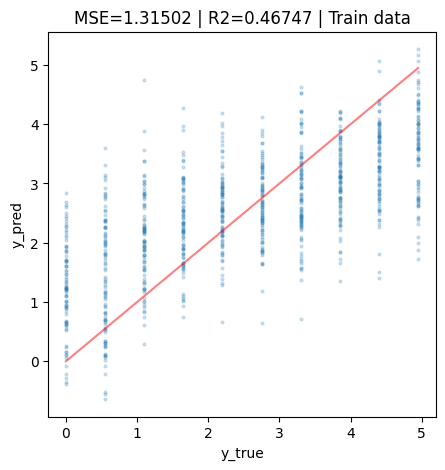

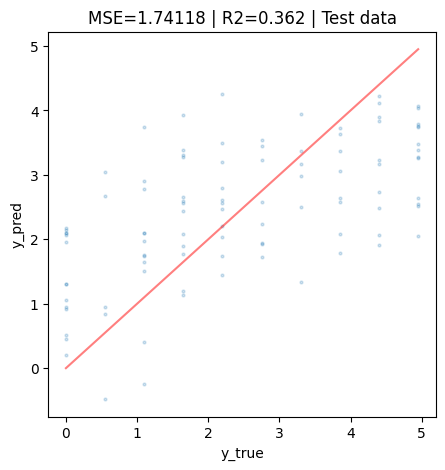

(1.7411761905204164, 0.3620019786488631)

In [31]:
scatter_prediction(model, x_train, y_train, "Train data")
scatter_prediction(model, x_test, y_test, "Test data")

## GridSearch for mlp Adam

In [ ]:
parameters = {'alpha': [0, 0.001],
              #'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'learning_rate_init': [0.0001, 0.01],
              'beta_1': [0.8, 0.99],
              'beta_2': [0.99, 1],
              }
model_gs = RandomizedSearchCV(model, parameters, verbose=3) #GridSearchCV
model_gs

RandomizedSearchCV(estimator=MLPRegressor(activation='tanh',
                                          early_stopping=True,
                                          hidden_layer_sizes=500,
                                          learning_rate='adaptive',
                                          n_iter_no_change=100,
                                          validation_fraction=0.2857),
                   param_distributions={'alpha': [0, 0.001],
                                        'beta_1': [0.8, 0.99],
                                        'beta_2': [0.99, 1],
                                        'learning_rate_init': [0.0001, 0.01]},
                   verbose=3)

In [ ]:
model_gs.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=0, beta_1=0.8, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0, beta_1=0.8, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0, beta_1=0.8, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0, beta_1=0.8, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0, beta_1=0.8, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.001, beta_1=0.99, beta_2=0.99, learning_rate_init=0.01;, score=0.219 total time=   1.0s
[CV 2/5] END alpha=0.001, beta_1=0.99, beta_2=0.99, learning_rate_init=0.01;, score=0.306 total time=   0.9s
[CV 3/5] END alpha=0.001, beta_1=0.99, beta_2=0.99, learning_rate_init=0.01;, score=0.132 total time=   1.0s
[CV 4/5] END alpha=0.001, beta_1=0.99, beta_2=0.99, learning_rate_init=0.01;, score=0.222 total time=   0.8

c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END alpha=0, beta_1=0.99, beta_2=0.99, learning_rate_init=0.0001;, score=0.251 total time=   1.3s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END alpha=0, beta_1=0.99, beta_2=0.99, learning_rate_init=0.0001;, score=0.327 total time=   1.3s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END alpha=0, beta_1=0.99, beta_2=0.99, learning_rate_init=0.0001;, score=0.166 total time=   1.3s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END alpha=0, beta_1=0.99, beta_2=0.99, learning_rate_init=0.0001;, score=0.268 total time=   1.4s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END alpha=0, beta_1=0.99, beta_2=0.99, learning_rate_init=0.0001;, score=0.235 total time=   1.4s
[CV 1/5] END alpha=0.001, beta_1=0.8, beta_2=0.99, learning_rate_init=0.01;, score=0.188 total time=   0.9s
[CV 2/5] END alpha=0.001, beta_1=0.8, beta_2=0.99, learning_rate_init=0.01;, score=0.307 total time=   0.8s
[CV 3/5] END alpha=0.001, beta_1=0.8, beta_2=0.99, learning_rate_init=0.01;, score=0.203 total time=   0.7s
[CV 4/5] END alpha=0.001, beta_1=0.8, beta_2=0.99, learning_rate_init=0.01;, score=0.196 total time=   0.8s
[CV 5/5] END alpha=0.001, beta_1=0.8, beta_2=0.99, learning_rate_init=0.01;, score=0.255 total time=   0.8s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END alpha=0, beta_1=0.8, beta_2=0.99, learning_rate_init=0.0001;, score=0.248 total time=   1.4s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END alpha=0, beta_1=0.8, beta_2=0.99, learning_rate_init=0.0001;, score=0.314 total time=   1.5s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END alpha=0, beta_1=0.8, beta_2=0.99, learning_rate_init=0.0001;, score=0.161 total time=   1.4s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END alpha=0, beta_1=0.8, beta_2=0.99, learning_rate_init=0.0001;, score=0.197 total time=   1.5s


c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END alpha=0, beta_1=0.8, beta_2=0.99, learning_rate_init=0.0001;, score=0.193 total time=   1.4s
[CV 1/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0, beta_1=0.99, beta_2=1, learning_rate_init=0.0001;, score=nan total

c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\base.py", line 666,

RandomizedSearchCV(estimator=MLPRegressor(activation='tanh',
                                          early_stopping=True,
                                          hidden_layer_sizes=500,
                                          learning_rate='adaptive',
                                          n_iter_no_change=100,
                                          validation_fraction=0.2857),
                   param_distributions={'alpha': [0, 0.001],
                                        'beta_1': [0.8, 0.99],
                                        'beta_2': [0.99, 1],
                                        'learning_rate_init': [0.0001, 0.01]},
                   verbose=3)

In [27]:
model_gs.best_estimator_, model_gs.best_params_, model_gs.best_score_

(MLPRegressor(activation='tanh', alpha=0, beta_1=0.99, beta_2=0.99,
              early_stopping=True, hidden_layer_sizes=500,
              learning_rate='adaptive', learning_rate_init=0.0001,
              n_iter_no_change=100, validation_fraction=0.2857),
 {'learning_rate_init': 0.0001, 'beta_2': 0.99, 'beta_1': 0.99, 'alpha': 0},
 0.24944055368599533)

## KAN

In [32]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

tc_x_train = torch.from_numpy(x_train)
tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
tc_x_test = torch.from_numpy(x_test)
tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

In [8]:
tc_x_train.double()

tensor([[-9.9522e-01,  1.4156e+00,  6.8950e-01,  ..., -1.4325e+00,
         -5.4759e-01,  8.8661e-01],
        [-2.9933e-01, -1.0985e+00,  1.2313e+00,  ..., -4.5042e-02,
          3.9436e-01,  1.0344e-01],
        [-1.9800e-03,  1.8184e-01, -4.2344e-01,  ..., -2.9044e-01,
         -5.5665e-01,  1.6494e+00],
        ...,
        [ 9.9539e-01,  1.3049e+00,  2.8389e+00,  ..., -1.0077e+00,
          1.7077e+00,  4.4925e-01],
        [-2.0762e+00, -1.6642e+00, -1.8293e+00,  ..., -2.1309e+00,
         -1.3356e+00, -8.5264e-01],
        [-8.4138e-01, -6.9989e-01, -8.7874e-01,  ...,  6.6283e-01,
         -1.4986e+00, -1.8291e+00]], dtype=torch.float64)

In [33]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
INPUT_SHAPE = tc_x_test.shape[1]

## Grid = 5 | hidden neurons = 5

In [34]:
model = KAN(width=[INPUT_SHAPE, 5, 1], grid=5, k=K)

KeyboardInterrupt: 

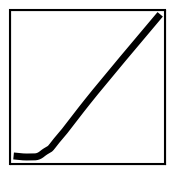

In [35]:
model(dataset['train_input'])
model.plot(beta=100)

In [36]:
result = model.train(dataset, opt="LBFGS", steps=50)

train loss: 8.29e-01 | test loss: 1.60e+00 | reg: 2.58e+01 : 100%|██| 50/50 [01:50<00:00,  2.22s/it]


Text(0.5, 0, 'step')

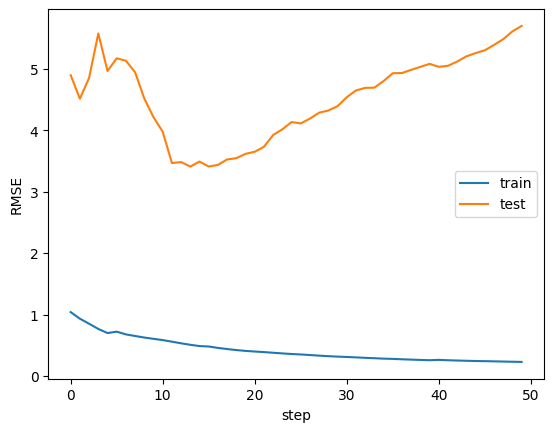

In [42]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')

## Grid=10 | hidden neurons = 5

In [33]:
model = KAN(width=[INPUT_SHAPE, 5, 1], grid=10, k=K, seed=None)

result = model.train(dataset, opt="LBFGS", steps=50)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 3.65e-01 | test loss: 1.86e+00 | reg: 2.45e+01 : 100%|██| 50/50 [04:07<00:00,  4.95s/it]


Text(0.5, 0, 'step')

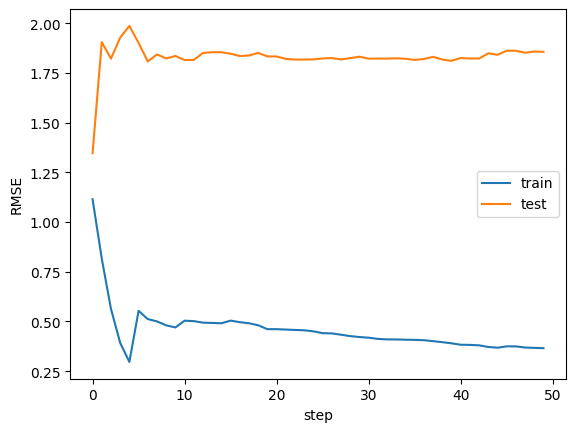

In [38]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

### Gradially increasing grid

In [14]:
width = [INPUT_SHAPE, 5, 1]
grids = np.array([3, 5, 8, 12])

train_losses = []
test_losses = []
steps = 50

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 4.57e-01 | test loss: 9.25e+00 | reg: 3.79e+01 : 100%|██| 50/50 [03:24<00:00,  4.10s/it]
train loss: 1.89e-01 | test loss: 1.43e+01 | reg: 4.09e+01 : 100%|██| 50/50 [03:30<00:00,  4.20s/it]
train loss: 1.47e-01 | test loss: 3.57e+04 | reg: 4.09e+01 : 100%|██| 50/50 [03:57<00:00,  4.75s/it]
train loss: 1.36e-03 | test loss: 4.35e+02 | reg: 4.03e+01 : 100%|██| 50/50 [04:16<00:00,  5.12s/it]


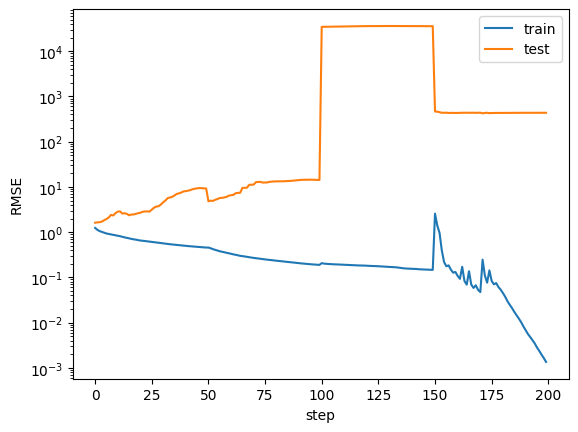

In [15]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

## Grid=10 | hidden neurons = 10

In [31]:
model = KAN(width=[INPUT_SHAPE, 10, 1], grid=10, k=K, seed=0)

result = model.train(dataset, opt="LBFGS", steps=10)

train loss: 1.36e-01 | test loss: 2.03e+00 | reg: 3.10e+01 : 100%|██| 10/10 [01:21<00:00,  8.18s/it]


Text(0.5, 0, 'step')

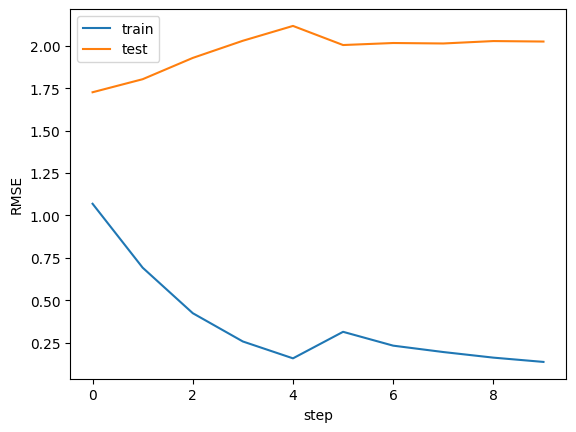

In [32]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

## Grid=10 | hidden neurons = 15

In [26]:
model = KAN(width=[INPUT_SHAPE, 15, 1], grid=10, k=K, seed=0)

result = model.train(dataset, opt='Adam', steps=50)

train loss: 1.78e+01 | test loss: 1.88e+01 | reg: 2.67e+03 : 100%|██| 50/50 [00:45<00:00,  1.10it/s]


Text(0.5, 0, 'step')

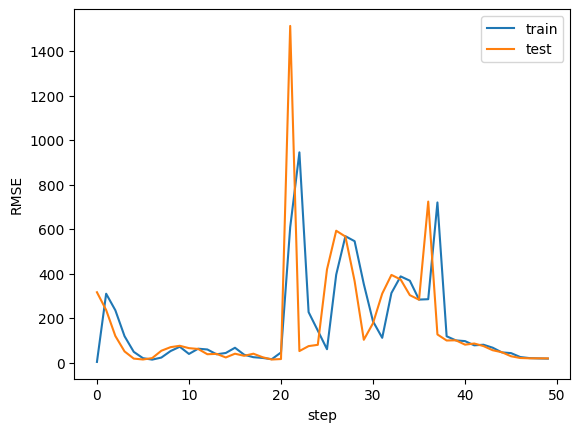

In [27]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

In [28]:
model = KAN(width=[INPUT_SHAPE, 15, 1], grid=10, k=K, seed=0)

result = model.train(dataset, opt="LBFGS", steps=10)

train loss: 5.02e-01 | test loss: 3.23e+00 | reg: 3.47e+01 : 100%|██| 10/10 [02:17<00:00, 13.73s/it]


Text(0.5, 0, 'step')

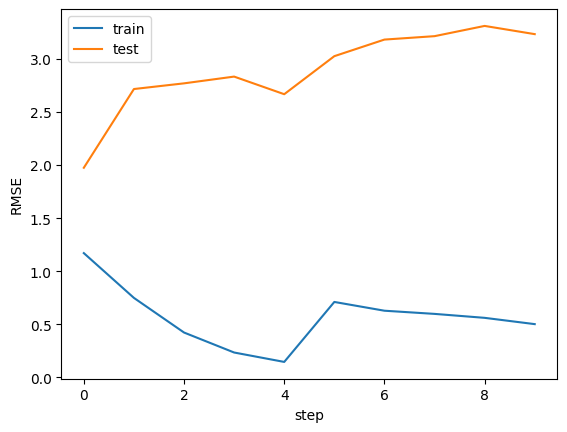

In [30]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

### Gradially increasing grid

In [21]:
width = [INPUT_SHAPE, 15, 1]
grids = np.array([3, 5, 8, 12])

train_losses = []
test_losses = []
steps = 10

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, 
                          update_grid = True, 
                          grid_update_num=6,
                          stop_grid_update_step=6)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 6.59e-01 | test loss: 3.86e+00 | reg: 3.97e+01 : 100%|██| 10/10 [01:50<00:00, 11.08s/it]
train loss: 3.26e-01 | test loss: 4.03e+00 | reg: 4.17e+01 : 100%|██| 10/10 [02:01<00:00, 12.11s/it]
train loss: 3.14e-01 | test loss: 9.43e+02 | reg: 4.17e+01 : 100%|██| 10/10 [02:25<00:00, 14.54s/it]
train loss: 3.15e-01 | test loss: 2.13e+02 | reg: 4.16e+01 : 100%|██| 10/10 [03:02<00:00, 18.23s/it]


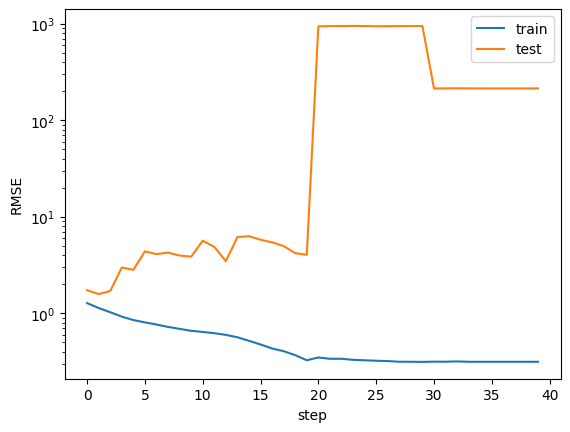

In [22]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

## Grid=10 | hidden neurons = 20

In [51]:
model = KAN(width=[INPUT_SHAPE, 20, 1], grid=10, k=K, seed=0)

result = model.train(dataset, opt="LBFGS", steps=7, lamb=0.01, lamb_entropy=10.)

train loss: 1.09e+00 | test loss: 2.28e+00 | reg: 1.22e+02 : 100%|████| 7/7 [02:02<00:00, 17.47s/it]


Text(0.5, 0, 'step')

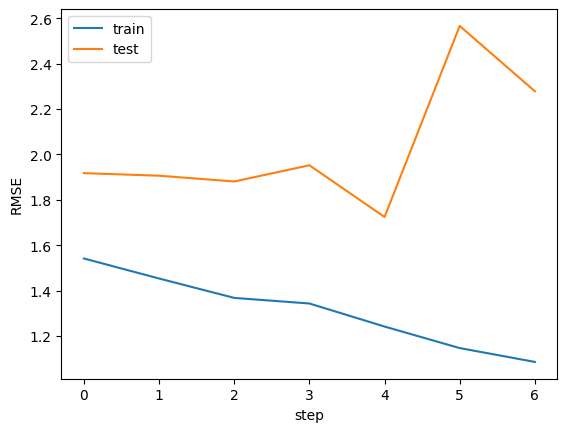

In [52]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

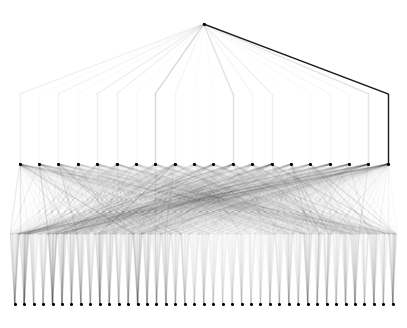

In [53]:
model.plot(beta=3)

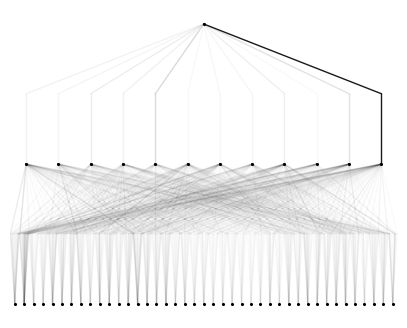

In [54]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()

In [57]:
result2 = model2.train(dataset, opt="LBFGS", steps=5, lamb=0.01, lamb_entropy=10.)

train loss: 7.42e-02 | test loss: 1.85e+00 | reg: 9.85e+01 : 100%|████| 5/5 [00:52<00:00, 10.59s/it]


In [ ]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

### Gradially increasing grid

In [17]:
width = [INPUT_SHAPE, 20, 1]
grids = np.array([3, 5, 8, 12])

train_losses = []
test_losses = []
steps = 10

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, 
                          update_grid = True, 
                          grid_update_num=6,
                          stop_grid_update_step=6)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

description:   0%|                                                           | 0/10 [00:00<?, ?it/s]

train loss: 6.54e-01 | test loss: 2.20e+00 | reg: 4.34e+01 : 100%|██| 10/10 [02:19<00:00, 13.93s/it]
train loss: 6.82e-01 | test loss: 6.69e+03 | reg: 4.30e+01 : 100%|██| 10/10 [02:33<00:00, 15.37s/it]
train loss: 5.54e-01 | test loss: 5.83e+02 | reg: 4.33e+01 : 100%|██| 10/10 [02:58<00:00, 17.89s/it]
train loss: 5.50e-01 | test loss: 5.92e+03 | reg: 4.33e+01 : 100%|██| 10/10 [01:17<00:00,  7.79s/it]


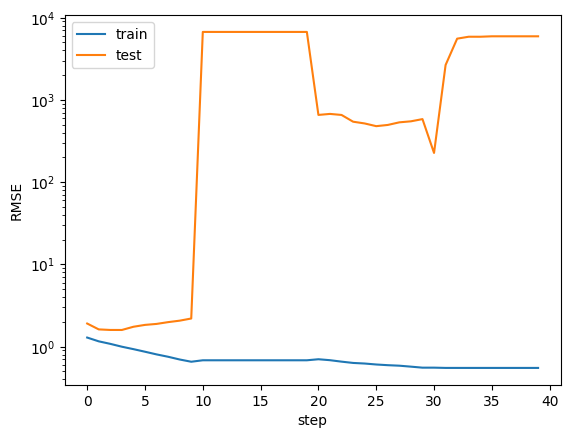

In [18]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')